# Task 1


In [3]:
# Task 1

import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, ReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from Unet import conv_block, get_unet
from Functions import plotcurve

# Define your parameters
base = 8
img_h = 256
img_w = 256
img_ch = 1
batch_size = 8
learning_rate = 1e-4
dropout = True
dr = 0.2
batch_norm = True
num_epochs = 50

# Set data directory
data_dir = '../Data/Lab3/CT/'

# List all image and mask file paths
image_files = [os.path.join(data_dir, 'Image', filename) for filename in os.listdir(os.path.join(data_dir, 'Image'))]
mask_files = [os.path.join(data_dir, 'Mask', filename) for filename in os.listdir(os.path.join(data_dir, 'Mask'))]

# Combine image and mask file paths into pairs
data_pairsa = list(zip(image_files, mask_files))

# Randomly shuffle the data pairs
random.shuffle(data_pairsa)

# Split the data into training and validation sets (80% for training, 20% for validation)
train_sizea = int(0.8 * len(data_pairsa))
train_dataa = data_pairsa[:train_sizea]
val_dataa = data_pairsa[train_sizea:]

# Image and mask normalization function
def normalize_image(image):
    image_array = img_to_array(image)
    normalized_image = image_array / 255.0
    return normalized_image

# Data generators for loading and preprocessing images and masks
def data_generator(data, batch_size):
    while True:
        batch_indices = np.random.choice(len(data), batch_size)
        batch_images = []
        batch_masks = []
        for idx in batch_indices:
            image_path, mask_path = data[idx]
            image = load_img(image_path, color_mode='grayscale', target_size=(img_h, img_w))
            mask = load_img(mask_path, color_mode='grayscale', target_size=(img_h, img_w))
            normalized_image = normalize_image(image)
            
            # Load the mask and binarize it
            mask_array = img_to_array(mask)
            binarized_mask = (mask_array > 0).astype(np.uint8)

            batch_images.append(normalized_image)
            batch_masks.append(binarized_mask)

        yield np.array(batch_images), np.array(batch_masks)

# Create the U-Net model
modela = get_unet(img_h, img_w, img_ch, base, batch_norm, dropout, dr)


# Define the Dice loss function
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true has the same data type as y_pred
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + 1e-5) / (union + 1e-5)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

# Define precision metric
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

# Define recall metric
def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    actual_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())
    return recall

# Compile the model
modela.compile(optimizer=Adam(learning_rate), loss=dice_loss, metrics=['binary_accuracy',dice_coefficient,precision,recall])

# Train the model
train_generatora = data_generator(train_dataa, batch_size)
val_generatora = data_generator(val_dataa, batch_size)

historya = modela.fit(
    train_generatora,
    validation_data=val_generatora,
    epochs=num_epochs,
    steps_per_epoch=len(train_dataa) // batch_size,
    validation_steps=len(val_dataa) // batch_size)

plotcurve(historya,'binary')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 8)  80          ['input_2[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 8)  32         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                            

                                                                                                  
 batch_normalization_26 (BatchN  (None, 16, 16, 128)  512        ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_26 (ReLU)                (None, 16, 16, 128)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 16, 16, 128)  147584      ['re_lu_26[0][0]']               
                                                                                                  
 batch_normalization_27 (BatchN  (None, 16, 16, 128)  512        ['conv2d_28[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 256, 256, 8)  520        ['re_lu_33[0][0]']               
 spose)                                                                                           
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 16  0           ['conv2d_transpose_7[0][0]',     
                                )                                 're_lu_19[0][0]']               
                                                                                                  
 dropout_15 (Dropout)           (None, 256, 256, 16  0           ['concatenate_7[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_35

KeyboardInterrupt: 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 8)  80          ['input_2[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 8)  32         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                            

                                                                                                  
 batch_normalization_26 (BatchN  (None, 16, 16, 128)  512        ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_26 (ReLU)                (None, 16, 16, 128)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 16, 16, 128)  147584      ['re_lu_26[0][0]']               
                                                                                                  
 batch_normalization_27 (BatchN  (None, 16, 16, 128)  512        ['conv2d_28[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 256, 256, 8)  520        ['re_lu_33[0][0]']               
 spose)                                                                                           
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 16  0           ['conv2d_transpose_7[0][0]',     
                                )                                 're_lu_19[0][0]']               
                                                                                                  
 dropout_15 (Dropout)           (None, 256, 256, 16  0           ['concatenate_7[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_35

Epoch 19/50
841/841 [==============================] - 82s 97ms/step - loss: 0.0244 - binary_accuracy: 0.9881 - dice_coefficient: 0.9756 - precision: 0.9752 - recall: 0.9764 - val_loss: 0.3489 - val_binary_accuracy: 0.8313 - val_dice_coefficient: 0.6511 - val_precision: 0.6946 - val_recall: 0.6169
Epoch 20/50
841/841 [==============================] - 82s 98ms/step - loss: 0.0260 - binary_accuracy: 0.9887 - dice_coefficient: 0.9740 - precision: 0.9722 - recall: 0.9763 - val_loss: 0.3715 - val_binary_accuracy: 0.8351 - val_dice_coefficient: 0.6285 - val_precision: 0.7459 - val_recall: 0.5458
Epoch 21/50
841/841 [==============================] - 82s 98ms/step - loss: 0.0177 - binary_accuracy: 0.9924 - dice_coefficient: 0.9823 - precision: 0.9809 - recall: 0.9839 - val_loss: 0.3623 - val_binary_accuracy: 0.8367 - val_dice_coefficient: 0.6377 - val_precision: 0.7412 - val_recall: 0.5631
Epoch 22/50
841/841 [==============================] - 83s 99ms/step - loss: 0.0236 - binary_accuracy: 

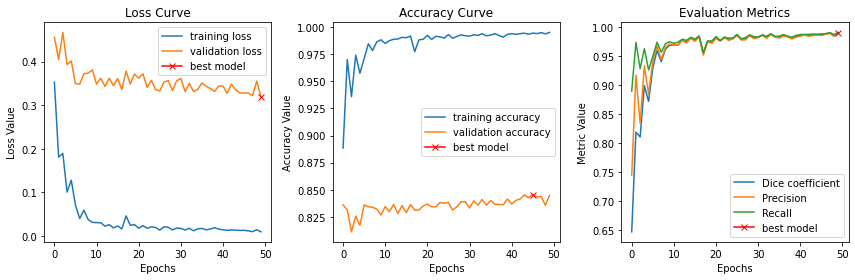

In [2]:
#TASK 1B

from Unet import conv_block, get_unet
from Functions import plotcurve
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, ReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define your parameters
base = 8  
img_h = 256
img_w = 256
img_size = 256
img_ch = 1
batch_size = 8
learning_rate = 1e-4
dropout = True
batch_norm = True  
num_epochs = 50


# Combine image and mask file paths into pairs
data_pairsb = list(zip(image_files, mask_files))

# Randomly shuffle the data pairs
random.shuffle(data_pairsb)

# Split the data into training and validation sets (80% for training, 20% for validation)
train_sizeb = int(0.8 * len(data_pairsb))
train_datab = data_pairsb[:train_sizeb]
val_datab = data_pairsb[train_sizeb:]


# Define data augmentation parameters
data_gen_args = {
    'rotation_range': 10,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'zoom_range': 0.2,
    'horizontal_flip': True
}

# Create data generators with augmentation
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

def data_generator_with_augmentation(data, batch_size, image_datagen, mask_datagen, img_size):
    while True:
        batch_indices = np.random.choice(len(data), batch_size)
        batch_images = []
        batch_masks = []
        for idx in batch_indices:
            image_path, mask_path = data[idx]
            
            # Load images
            image = load_img(image_path, color_mode='grayscale', target_size=(img_size, img_size))
            mask = load_img(mask_path, color_mode='grayscale', target_size=(img_size, img_size))
            
            # Ensure the shape matches the model's input shape
            image = np.expand_dims(image, axis=-1)
            mask = np.expand_dims(mask, axis=-1)
            
            seed = np.random.randint(1, 1000)
            
            # Apply the same augmentation to both image and mask
            augmented_image = image_datagen.random_transform(image, seed=seed)
            augmented_mask = mask_datagen.random_transform(mask, seed=seed)
            
            # Normalize augmented images
            normalized_image = normalize_image(augmented_image)
            
            # Binarize the mask
            mask_array = img_to_array(augmented_mask)
            binarized_mask = (mask_array > 0).astype(np.uint8)
            
            batch_images.append(normalized_image)
            batch_masks.append(binarized_mask)
        yield np.array(batch_images), np.array(batch_masks)


# Call U-Net with batch_norm=True and base=16
modelb = get_unet(img_h, img_w, img_ch, base, batch_norm, dropout, dr)

# Compile the model
modelb.compile(optimizer=Adam(learning_rate), loss=dice_loss, metrics=['binary_accuracy',dice_coefficient,precision,recall])

# Create data generators with augmentation and binarization
train_generatorb = data_generator_with_augmentation(train_datab, batch_size, image_datagen, mask_datagen, img_size)
val_generatorb = data_generator_with_augmentation(val_datab, batch_size, image_datagen, mask_datagen, img_size)

historyb = modelb.fit(
    train_generatorb,
    validation_data=val_generatorb,
    epochs=num_epochs,
    steps_per_epoch=len(train_datab)// batch_size,
    validation_steps=len(val_datab) // batch_size)
    
import matplotlib.pyplot as plt

# After training, call the function to plot the metrics
plotcurve(historyb,'binary')

# Task 2


In [1]:
import cv2
import numpy as np

# Load the mask image
mask_image = cv2.imread('../Data/Lab3/CT/Mask/Im0_68_Mask.png', cv2.IMREAD_GRAYSCALE)  # Load the image as grayscale

# Find unique values in the mask image
unique_values = np.unique(mask_image)

# Print the unique values
print("Unique values in the mask image:")
for value in unique_values:
    print(value)

Unique values in the mask image:
0
156
251


In [4]:
#TASK 2
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, ReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from Unet import conv_block, get_multi_class_unet
from Functions import plotcurve

# Define your parameters
base = 8
img_h = 256
img_w = 256
img_ch = 1
batch_size = 8
learning_rate = 1e-4
dropout = True
dr = 0.2
batch_norm = True
num_epochs = 50

# Set data directory
data_dir = '../Data/Lab3/CT/'

# List all image and mask file paths
image_files = [os.path.join(data_dir, 'Image', filename) for filename in os.listdir(os.path.join(data_dir, 'Image'))]
mask_files = [os.path.join(data_dir, 'Mask', filename) for filename in os.listdir(os.path.join(data_dir, 'Mask'))]

# Combine image and mask file paths into pairs
data_pairs = list(zip(image_files, mask_files))

# Randomly shuffle the data pairs
random.shuffle(data_pairs)

# Split the data into training and validation sets (80% for training, 20% for validation)
train_size = int(0.8 * len(data_pairs))
train_data = data_pairs[:train_size]
val_data = data_pairs[train_size:]

# Image and mask normalization function
def normalize_image(image):
    image_array = img_to_array(image)
    normalized_image = image_array / 255.0
    return normalized_image

# Update the data generator to one-hot encode the masks
def data_generator(data, batch_size):
    while True:
        batch_indices = np.random.choice(len(data), batch_size)
        batch_images = []
        batch_masks = []
        for idx in batch_indices:
            image_path, mask_path = data[idx]
            image = load_img(image_path, color_mode='grayscale', target_size=(img_h, img_w))
            mask = load_img(mask_path, color_mode='grayscale', target_size=(img_h, img_w))
            normalized_image = normalize_image(image)

            # Load the mask and convert to one-hot encoding
            mask_array = img_to_array(mask)
            one_hot_mask = np.zeros((img_h, img_w, 2), dtype=np.uint8)
            
            # Apply boolean indexing correctly by comparing with integers (156 and 251)
            one_hot_mask[:, :, 0] = (mask_array[:, :, 0] == 156).astype(np.uint8)  # Left lung
            one_hot_mask[:, :, 1] = (mask_array[:, :, 0] == 251).astype(np.uint8)  # Right lung

            batch_images.append(normalized_image)
            batch_masks.append(one_hot_mask)

        yield np.array(batch_images), np.array(batch_masks)

# Create the U-Net model for multi-organ segmentation
model = get_multi_class_unet(img_h, img_w, img_ch, 2, base, batch_norm, dropout, dr)

# Define the categorical cross-entropy loss function
model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',dice_coefficient,precision,recall])

# Train the model
train_generator = data_generator(train_data, batch_size)
val_generator = data_generator(val_data, batch_size)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_data) // batch_size,
    validation_steps=len(val_data) // batch_size)

plotcurve(history, 'ac')


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 4)  40          ['input_3[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 4)  16         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                            

 ormalization)                                                                                    
                                                                                                  
 re_lu_44 (ReLU)                (None, 16, 16, 64)   0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 16, 16, 64)   36928       ['re_lu_44[0][0]']               
                                                                                                  
 batch_normalization_45 (BatchN  (None, 16, 16, 64)  256         ['conv2d_47[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_45 (ReLU)                (None, 16, 16, 64)   0           ['batch_normalization_45[0][0]'] 
          

                                                                                                  
 dropout_23 (Dropout)           (None, 256, 256, 8)  0           ['concatenate_11[0][0]']         
                                                                                                  
 conv2d_54 (Conv2D)             (None, 256, 256, 4)  292         ['dropout_23[0][0]']             
                                                                                                  
 batch_normalization_52 (BatchN  (None, 256, 256, 4)  16         ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_52 (ReLU)                (None, 256, 256, 4)  0           ['batch_normalization_52[0][0]'] 
                                                                                                  
 conv2d_55

KeyboardInterrupt: 

# Bonus task

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 240, 240, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 240, 240, 16  64         ['conv2d_38[0][0]']              
 ormalization)                  )                                                           

 batch_normalization_44 (BatchN  (None, 15, 15, 256)  1024       ['conv2d_46[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_44 (ReLU)                (None, 15, 15, 256)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 15, 15, 256)  590080      ['re_lu_44[0][0]']               
                                                                                                  
 batch_normalization_45 (BatchN  (None, 15, 15, 256)  1024       ['conv2d_47[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_45 

                                )                                                                 
                                                                                                  
 batch_normalization_52 (BatchN  (None, 240, 240, 16  64         ['conv2d_54[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 re_lu_52 (ReLU)                (None, 240, 240, 16  0           ['batch_normalization_52[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 240, 240, 16  2320        ['re_lu_52[0][0]']               
                                )                                                                 
          

235/235 [==============================] - 32s 135ms/step - loss: 0.5583 - binary_accuracy: 0.9867 - dice_coefficient: 0.4417 - precision: 0.5134 - recall: 0.3925 - val_loss: 0.9457 - val_binary_accuracy: 0.9793 - val_dice_coefficient: 0.0543 - val_precision: 0.0772 - val_recall: 0.0432
Epoch 49/50
235/235 [==============================] - 32s 135ms/step - loss: 0.5587 - binary_accuracy: 0.9867 - dice_coefficient: 0.4413 - precision: 0.5192 - recall: 0.3880 - val_loss: 0.9540 - val_binary_accuracy: 0.9827 - val_dice_coefficient: 0.0460 - val_precision: 0.0937 - val_recall: 0.0320
Epoch 50/50
235/235 [==============================] - 32s 135ms/step - loss: 0.5379 - binary_accuracy: 0.9872 - dice_coefficient: 0.4621 - precision: 0.5424 - recall: 0.4068 - val_loss: 0.9442 - val_binary_accuracy: 0.9784 - val_dice_coefficient: 0.0558 - val_precision: 0.0728 - val_recall: 0.0473


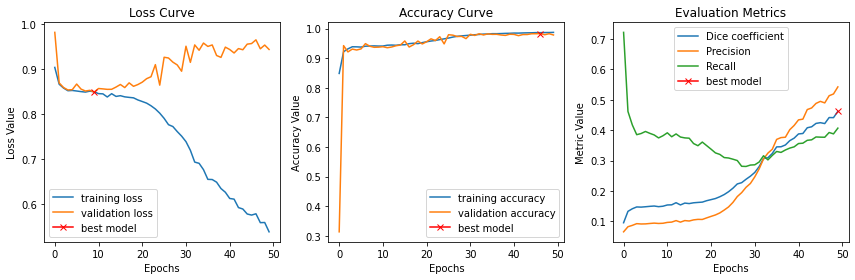

In [3]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, ReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from Unet import conv_block, get_unet
from Functions import plotcurve

# Define your parameters
base = 16  # Increase the model's capacity
img_h = 240  # Use a larger input image size
img_w = 240
img_ch = 1  # Use 3 channels for color images
batch_size = 32  # Use a larger batch size for more stable training
learning_rate = 1e-3  # Increase the learning rate for faster convergence
dropout = False  # Turn off dropout initially
dr = 0.0  # Set dropout rate to 0%
batch_norm = True  # Use batch normalization for better convergence
num_epochs = 50  # Increase the number of training epochs

# Set data directory
data_dirb = '../Data/Lab3/MRI/'

# List all image and mask file paths
image_filese = [os.path.join(data_dirb, 'Image', filename) for filename in os.listdir(os.path.join(data_dirb, 'Image'))]
mask_filese = [os.path.join(data_dirb, 'Mask', filename) for filename in os.listdir(os.path.join(data_dirb, 'Mask'))]

# Combine image and mask file paths into pairs
data_pairse = list(zip(image_filese, mask_filese))

# Randomly shuffle the data pairs
random.shuffle(data_pairse)

# Split the data into training and validation sets (80% for training, 20% for validation)
train_sizee = int(0.8 * len(data_pairse))
train_datae = data_pairse[:train_sizee]
val_datae = data_pairse[train_sizee:]

# Image and mask normalization function
def normalize_image(image):
    image_array = img_to_array(image)
    normalized_image = image_array / 255.0
    return normalized_image

# Data generators for loading and preprocessing images and masks
def data_generator(data, batch_size):
    while True:
        batch_indices = np.random.choice(len(data), batch_size)
        batch_images = []
        batch_masks = []
        for idx in batch_indices:
            image_path, mask_path = data[idx]
            image = load_img(image_path, color_mode='grayscale', target_size=(img_h, img_w))
            mask = load_img(mask_path, color_mode='grayscale', target_size=(img_h, img_w))
            normalized_image = normalize_image(image)
            
            # Load the mask and binarize it
            mask_array = img_to_array(mask)
            binarized_mask = (mask_array > 0).astype(np.uint8)

            batch_images.append(normalized_image)
            batch_masks.append(binarized_mask)

        yield np.array(batch_images), np.array(batch_masks)

# Create the U-Net model
modele = get_unet(img_h, img_w, img_ch, base, batch_norm, dropout, dr)


# Compile the model
modele.compile(optimizer=Adam(learning_rate), loss=dice_loss, metrics=['binary_accuracy',dice_coefficient,precision,recall])

# Train the model
train_generatore = data_generator(train_datae, batch_size)
val_generatore = data_generator(val_datae, batch_size)

historye = modele.fit(
    train_generatore,
    validation_data=val_generatore,
    epochs=num_epochs,
    steps_per_epoch=len(train_datae) // batch_size,
    validation_steps=len(val_datae) // batch_size)

plotcurve(historye,'binary')

# Task 3


In [ ]:
def split_data_for_fold(image_files, mask_files, fold, total_folds):
    n = len(image_files)
    fold_size = n // total_folds
    start_idx = (fold - 1) * fold_size
    end_idx = fold * fold_size

    validation_images = image_files[start_idx:end_idx]
    validation_masks = mask_files[start_idx:end_idx]

    training_images = image_files[:start_idx] + image_files[end_idx:]
    training_masks = mask_files[:start_idx] + mask_files[end_idx:]

    return training_images, training_masks, validation_images, validation_masks

# inputs

total_folds = 3
base = 8
img_h = 256
img_w = 256
img_ch = 1
batch_size = 8
learning_rate = 1e-4
dropout = True
dr = 0.2
batch_norm = True
num_epochs = 50

# Set data directory
data_dir = '../Data/Lab3/CT/'

# List all image and mask file paths
image_files = [os.path.join(data_dir, 'Image', filename) for filename in os.listdir(os.path.join(data_dir, 'Image'))]
mask_files = [os.path.join(data_dir, 'Mask', filename) for filename in os.listdir(os.path.join(data_dir, 'Mask'))]
# Combine image and mask file paths into pairs
data_pairs = list(zip(image_files, mask_files))

# Randomly shuffle the data pairs
random.shuffle(data_pairs)

# Initialize lists to store validation metrics for each fold
validation_metrics = []

# Perform K-fold cross-validation
for fold in range(1, total_folds + 1):
    print(f"Training and evaluating on fold {fold}/{total_folds}...")

    # Split the data using the split_data_for_fold function
    training_images, training_masks, validation_images, validation_masks = split_data_for_fold(
        image_files, mask_files, fold, total_folds)

    # Create the U-Net model
    model = get_unet(img_h, img_w, img_ch, base, batch_norm, dropout, dr)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate), loss=dice_loss, metrics=['binary_accuracy', dice_coefficient, precision, recall])

    # Data generators for loading and preprocessing images and masks
    train_data = list(zip(training_images, training_masks))
    val_data = list(zip(validation_images, validation_masks))

    train_generator = data_generator(train_data, batch_size)
    val_generator = data_generator(val_data, batch_size)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=num_epochs,
        steps_per_epoch=len(train_data) // batch_size,
        validation_steps=len(val_data) // batch_size,
        verbose=0  # Set to 1 for verbose training output
    )

    # Store validation metrics for this fold
    #validation_metrics.append(history)
    plotcurve(history, metrics='binary')

Training and evaluating on fold 1/3...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 8)  80          ['input_2[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 8)  32         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                     

                                                                                                  
 batch_normalization_26 (BatchN  (None, 16, 16, 128)  512        ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_26 (ReLU)                (None, 16, 16, 128)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 16, 16, 128)  147584      ['re_lu_26[0][0]']               
                                                                                                  
 batch_normalization_27 (BatchN  (None, 16, 16, 128)  512        ['conv2d_28[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 256, 256, 8)  520        ['re_lu_33[0][0]']               
 spose)                                                                                           
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 16  0           ['conv2d_transpose_7[0][0]',     
                                )                                 're_lu_19[0][0]']               
                                                                                                  
 dropout_15 (Dropout)           (None, 256, 256, 16  0           ['concatenate_7[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_35